In [1]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 898 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.9 MB/s 
     |████████████████████████████████| 168 kB 72.5 MB/s 
     |████████████████████████████████| 182 kB 68.0 MB/s 
     |████████████████████████████████| 62 kB 925 kB/s 
     |████████████████████████████████| 140 kB 73.4 MB/s 


In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [4]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Training Config
config = {
    "batch_size" : 32,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 126,
    "feature_dim" : 1,
    "hidden_dim" : 64,
    "output_dim" : 1,
    "num_layers" : 3,
    "dropout" : 0.2
}

In [6]:
# load all that we need
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Log Adj Close', 'Log Return', 10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * 100
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        return data
    
    def prepare_data(self, data):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization
        """
        vol_10 = data['10-day-vol'].values
        dataset = vol_10.reshape(-1, 1)[11:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
dataset, scaler = volatiltiy_data.prepare_data(data)
print(np.shape(dataset))

[*********************100%***********************]  1 of 1 completed
(8290, 1)


In [7]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, -1))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.dataset[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps].view(self.batch_size, time_steps, self.feature_size)
            label = y[:, index+time_steps].view(self.batch_size, self.feature_size)
            index += 1
            yield input, label

In [8]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, batch_size=config["batch_size"], sequence_length=config["look_back"])
tmp = iter(dataloader)
input, label = next(tmp)
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([32, 60, 1])
label shape = torch.Size([32, 1])


In [9]:
# model
class Model(torch.nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], 
                                  dropout=config["dropout"], batch_first=True, bidirectional=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim*2, out_features=output_dim, bias=True)

    def forward(self, x):
        x, h = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [10]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([32, 1])
shape of label : torch.Size([32, 1])
         Kernel Shape   Output Shape   Params Mult-Adds
Layer                                                  
0_lstm              -  [32, 60, 128]  232.96k  229.888k
1_relu              -      [32, 128]        -         -
2_linear     [128, 1]        [32, 1]    129.0     128.0
---------------------------------------------------------
                        Totals
Total params          233.089k
Trainable params      233.089k
Non-trainable params       0.0
Mult-Adds             230.016k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[32, 60, 128]",232960.0,229888.0
1_relu,-,"[32, 128]",NaN,NaN
2_linear,"[128, 1]","[32, 1]",129.0,128.0


In [11]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [12]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction.flatten(), target.flatten())

        val_loss += loss.item()
        # print(loss.item())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target

    batch_bar.close()
    val_loss /= len(dataloader)

    return val_loss

In [13]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [14]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_bidirectional", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: quantoalpha. Use `wandb login --relogin` to force relogin


In [15]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_bidrectional'
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler': scheduler_lr.state_dict(),
                    'val_loss': val_loss, 
                    'epoch': epoch}, path)
wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.0048966	 Eval Loss 0.0115029	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.0024215	 Eval Loss 0.0073462	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.0021606	 Eval Loss 0.0071660	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.0021737	 Eval Loss 0.0072702	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.0021637	 Eval Loss 0.0075179	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.0021487	 Eval Loss 0.0077388	 Learning Rate 0.0010	



Epoch 7/100: 
	 Train Loss 0.0021445	 Eval Loss 0.0078803	 Learning Rate 0.0010	



Epoch 8/100: 
	 Train Loss 0.0021344	 Eval Loss 0.0077552	 Learning Rate 0.0010	



Epoch 9/100: 
	 Train Loss 0.0021535	 Eval Loss 0.0082107	 Learning Rate 0.0010	



Epoch 10/100: 
	 Train Loss 0.0021878	 Eval Loss 0.0086602	 Learning Rate 0.0010	


Epoch 00011: reducing learning rate of group 0 to 7.5000e-04.

Epoch 11/100: 
	 Train Loss 0.0021996	 Eval Loss 0.0083797	 Learning Rate 0.0010	



Epoch 12/100: 
	 Train Loss 0.0021720	 Eval Loss 0.0075700	 Learning Rate 0.0008	



Epoch 13/100: 
	 Train Loss 0.0021520	 Eval Loss 0.0073481	 Learning Rate 0.0008	


Epoch 00014: reducing learning rate of group 0 to 5.6250e-04.

Epoch 14/100: 
	 Train Loss 0.0021502	 Eval Loss 0.0075430	 Learning Rate 0.0008	



Epoch 15/100: 
	 Train Loss 0.0021542	 Eval Loss 0.0071321	 Learning Rate 0.0006	



Epoch 16/100: 
	 Train Loss 0.0021415	 Eval Loss 0.0071183	 Learning Rate 0.0006	


Epoch 00017: reducing learning rate of group 0 to 4.2188e-04.

Epoch 17/100: 
	 Train Loss 0.0021548	 Eval Loss 0.0070723	 Learning Rate 0.0006	



Epoch 18/100: 
	 Train Loss 0.0021430	 Eval Loss 0.0069800	 Learning Rate 0.0004	



Epoch 19/100: 
	 Train Loss 0.0021546	 Eval Loss 0.0069437	 Learning Rate 0.0004	


Epoch 00020: reducing learning rate of group 0 to 3.1641e-04.

Epoch 20/100: 
	 Train Loss 0.0021428	 Eval Loss 0.0069041	 Learning Rate 0.0004	



Epoch 21/100: 
	 Train Loss 0.0021642	 Eval Loss 0.0070045	 Learning Rate 0.0003	



Epoch 22/100: 
	 Train Loss 0.0021604	 Eval Loss 0.0069872	 Learning Rate 0.0003	


Epoch 00023: reducing learning rate of group 0 to 2.3730e-04.

Epoch 23/100: 
	 Train Loss 0.0021554	 Eval Loss 0.0069814	 Learning Rate 0.0003	



Epoch 24/100: 
	 Train Loss 0.0021406	 Eval Loss 0.0069905	 Learning Rate 0.0002	



Epoch 25/100: 
	 Train Loss 0.0021253	 Eval Loss 0.0069864	 Learning Rate 0.0002	



Epoch 26/100: 
	 Train Loss 0.0021232	 Eval Loss 0.0069364	 Learning Rate 0.0002	



Epoch 27/100: 
	 Train Loss 0.0021250	 Eval Loss 0.0069612	 Learning Rate 0.0002	



Epoch 28/100: 
	 Train Loss 0.0021205	 Eval Loss 0.0069649	 Learning Rate 0.0002	



Epoch 29/100: 
	 Train Loss 0.0021012	 Eval Loss 0.0069366	 Learning Rate 0.0002	



Epoch 30/100: 
	 Train Loss 0.0021171	 Eval Loss 0.0069473	 Learning Rate 0.0002	



Epoch 31/100: 
	 Train Loss 0.0021047	 Eval Loss 0.0069248	 Learning Rate 0.0002	


Epoch 00032: reducing learning rate of group 0 to 1.7798e-04.

Epoch 32/100: 
	 Train Loss 0.0021066	 Eval Loss 0.0069419	 Learning Rate 0.0002	



Epoch 33/100: 
	 Train Loss 0.0021089	 Eval Loss 0.0068950	 Learning Rate 0.0002	



Epoch 34/100: 
	 Train Loss 0.0020855	 Eval Loss 0.0068856	 Learning Rate 0.0002	



Epoch 35/100: 
	 Train Loss 0.0020829	 Eval Loss 0.0068821	 Learning Rate 0.0002	



Epoch 36/100: 
	 Train Loss 0.0020982	 Eval Loss 0.0068625	 Learning Rate 0.0002	



Epoch 37/100: 
	 Train Loss 0.0020997	 Eval Loss 0.0068470	 Learning Rate 0.0002	


Epoch 00038: reducing learning rate of group 0 to 1.3348e-04.

Epoch 38/100: 
	 Train Loss 0.0020924	 Eval Loss 0.0068634	 Learning Rate 0.0002	



Epoch 39/100: 
	 Train Loss 0.0020978	 Eval Loss 0.0068139	 Learning Rate 0.0001	



Epoch 40/100: 
	 Train Loss 0.0020811	 Eval Loss 0.0068203	 Learning Rate 0.0001	



Epoch 41/100: 
	 Train Loss 0.0020840	 Eval Loss 0.0067858	 Learning Rate 0.0001	



Epoch 42/100: 
	 Train Loss 0.0020762	 Eval Loss 0.0067899	 Learning Rate 0.0001	



Epoch 43/100: 
	 Train Loss 0.0020818	 Eval Loss 0.0067872	 Learning Rate 0.0001	



Epoch 44/100: 
	 Train Loss 0.0020806	 Eval Loss 0.0067814	 Learning Rate 0.0001	



Epoch 45/100: 
	 Train Loss 0.0020656	 Eval Loss 0.0067678	 Learning Rate 0.0001	



Epoch 46/100: 
	 Train Loss 0.0020791	 Eval Loss 0.0067678	 Learning Rate 0.0001	



Epoch 47/100: 
	 Train Loss 0.0020791	 Eval Loss 0.0067701	 Learning Rate 0.0001	


Epoch 00048: reducing learning rate of group 0 to 1.0011e-04.

Epoch 48/100: 
	 Train Loss 0.0020850	 Eval Loss 0.0067686	 Learning Rate 0.0001	



Epoch 49/100: 
	 Train Loss 0.0020835	 Eval Loss 0.0067213	 Learning Rate 0.0001	



Epoch 50/100: 
	 Train Loss 0.0020499	 Eval Loss 0.0067277	 Learning Rate 0.0001	



Epoch 51/100: 
	 Train Loss 0.0020506	 Eval Loss 0.0066779	 Learning Rate 0.0001	



Epoch 52/100: 
	 Train Loss 0.0020503	 Eval Loss 0.0066985	 Learning Rate 0.0001	



Epoch 53/100: 
	 Train Loss 0.0020468	 Eval Loss 0.0067036	 Learning Rate 0.0001	



Epoch 54/100: 
	 Train Loss 0.0020409	 Eval Loss 0.0066994	 Learning Rate 0.0001	



Epoch 55/100: 
	 Train Loss 0.0020494	 Eval Loss 0.0066914	 Learning Rate 0.0001	



Epoch 56/100: 
	 Train Loss 0.0020491	 Eval Loss 0.0067118	 Learning Rate 0.0001	


Epoch 00057: reducing learning rate of group 0 to 7.5085e-05.

Epoch 57/100: 
	 Train Loss 0.0020432	 Eval Loss 0.0067087	 Learning Rate 0.0001	



Epoch 58/100: 
	 Train Loss 0.0020419	 Eval Loss 0.0066469	 Learning Rate 0.0001	



Epoch 59/100: 
	 Train Loss 0.0020471	 Eval Loss 0.0066496	 Learning Rate 0.0001	


Epoch 00060: reducing learning rate of group 0 to 5.6314e-05.

Epoch 60/100: 
	 Train Loss 0.0020453	 Eval Loss 0.0066629	 Learning Rate 0.0001	



Epoch 61/100: 
	 Train Loss 0.0020477	 Eval Loss 0.0065968	 Learning Rate 0.0001	



Epoch 62/100: 
	 Train Loss 0.0020642	 Eval Loss 0.0066081	 Learning Rate 0.0001	


Epoch 00063: reducing learning rate of group 0 to 4.2235e-05.

Epoch 63/100: 
	 Train Loss 0.0020738	 Eval Loss 0.0066143	 Learning Rate 0.0001	



Epoch 64/100: 
	 Train Loss 0.0020732	 Eval Loss 0.0065307	 Learning Rate 0.0000	



Epoch 65/100: 
	 Train Loss 0.0020987	 Eval Loss 0.0065399	 Learning Rate 0.0000	


Epoch 00066: reducing learning rate of group 0 to 3.1676e-05.

Epoch 66/100: 
	 Train Loss 0.0020991	 Eval Loss 0.0065466	 Learning Rate 0.0000	



Epoch 67/100: 
	 Train Loss 0.0020959	 Eval Loss 0.0065772	 Learning Rate 0.0000	



Epoch 68/100: 
	 Train Loss 0.0020879	 Eval Loss 0.0065849	 Learning Rate 0.0000	


Epoch 00069: reducing learning rate of group 0 to 2.3757e-05.

Epoch 69/100: 
	 Train Loss 0.0020802	 Eval Loss 0.0065920	 Learning Rate 0.0000	



Epoch 70/100: 
	 Train Loss 0.0020724	 Eval Loss 0.0066242	 Learning Rate 0.0000	



Epoch 71/100: 
	 Train Loss 0.0020582	 Eval Loss 0.0066194	 Learning Rate 0.0000	


Epoch 00072: reducing learning rate of group 0 to 1.7818e-05.

Epoch 72/100: 
	 Train Loss 0.0020647	 Eval Loss 0.0066122	 Learning Rate 0.0000	



Epoch 73/100: 
	 Train Loss 0.0020493	 Eval Loss 0.0066282	 Learning Rate 0.0000	



Epoch 74/100: 
	 Train Loss 0.0020452	 Eval Loss 0.0066253	 Learning Rate 0.0000	


Epoch 00075: reducing learning rate of group 0 to 1.3363e-05.

Epoch 75/100: 
	 Train Loss 0.0020471	 Eval Loss 0.0066307	 Learning Rate 0.0000	



Epoch 76/100: 
	 Train Loss 0.0020409	 Eval Loss 0.0066372	 Learning Rate 0.0000	



Epoch 77/100: 
	 Train Loss 0.0020412	 Eval Loss 0.0066386	 Learning Rate 0.0000	



Epoch 78/100: 
	 Train Loss 0.0020400	 Eval Loss 0.0066377	 Learning Rate 0.0000	



Epoch 79/100: 
	 Train Loss 0.0020371	 Eval Loss 0.0066383	 Learning Rate 0.0000	



Epoch 80/100: 
	 Train Loss 0.0020417	 Eval Loss 0.0066385	 Learning Rate 0.0000	



Epoch 81/100: 
	 Train Loss 0.0020306	 Eval Loss 0.0066397	 Learning Rate 0.0000	



Epoch 82/100: 
	 Train Loss 0.0020409	 Eval Loss 0.0066383	 Learning Rate 0.0000	



Epoch 83/100: 
	 Train Loss 0.0020357	 Eval Loss 0.0066365	 Learning Rate 0.0000	



Epoch 84/100: 
	 Train Loss 0.0020263	 Eval Loss 0.0066373	 Learning Rate 0.0000	



Epoch 85/100: 
	 Train Loss 0.0020272	 Eval Loss 0.0066357	 Learning Rate 0.0000	



Epoch 86/100: 
	 Train Loss 0.0020310	 Eval Loss 0.0066347	 Learning Rate 0.0000	


Epoch 00087: reducing learning rate of group 0 to 1.0023e-05.

Epoch 87/100: 
	 Train Loss 0.0020330	 Eval Loss 0.0066370	 Learning Rate 0.0000	



Epoch 88/100: 
	 Train Loss 0.0020260	 Eval Loss 0.0066423	 Learning Rate 0.0000	



Epoch 89/100: 
	 Train Loss 0.0020251	 Eval Loss 0.0066414	 Learning Rate 0.0000	



Epoch 90/100: 
	 Train Loss 0.0020225	 Eval Loss 0.0066404	 Learning Rate 0.0000	



Epoch 91/100: 
	 Train Loss 0.0020204	 Eval Loss 0.0066381	 Learning Rate 0.0000	



Epoch 92/100: 
	 Train Loss 0.0020225	 Eval Loss 0.0066369	 Learning Rate 0.0000	



Epoch 93/100: 
	 Train Loss 0.0020309	 Eval Loss 0.0066379	 Learning Rate 0.0000	



Epoch 94/100: 
	 Train Loss 0.0020146	 Eval Loss 0.0066359	 Learning Rate 0.0000	



Epoch 95/100: 
	 Train Loss 0.0020162	 Eval Loss 0.0066338	 Learning Rate 0.0000	



Epoch 96/100: 
	 Train Loss 0.0020215	 Eval Loss 0.0066351	 Learning Rate 0.0000	


Epoch 00097: reducing learning rate of group 0 to 7.5169e-06.

Epoch 97/100: 
	 Train Loss 0.0020233	 Eval Loss 0.0066332	 Learning Rate 0.0000	



Epoch 98/100: 
	 Train Loss 0.0020262	 Eval Loss 0.0066380	 Learning Rate 0.0000	



Epoch 99/100: 
	 Train Loss 0.0020237	 Eval Loss 0.0066400	 Learning Rate 0.0000	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch 00100: reducing learning rate of group 0 to 5.6377e-06.

Epoch 100/100: 
	 Train Loss 0.0020153	 Eval Loss 0.0066363	 Learning Rate 0.0000	


learning_Rate,█████▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▃▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_Rate,1e-05
train_loss,0.00202
val_loss,0.00664


In [16]:
state_dict = torch.load(path)
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [17]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        test_loss += criterion(prediction.flatten(), target.flatten())

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target
    
    test_loss /= len(test_loader)

    return preds, targets, test_loss

In [18]:
torch.cuda.empty_cache()
gc.collect()

preds, targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

Eval loss : 0.006530694
Test loss : 0.007055329


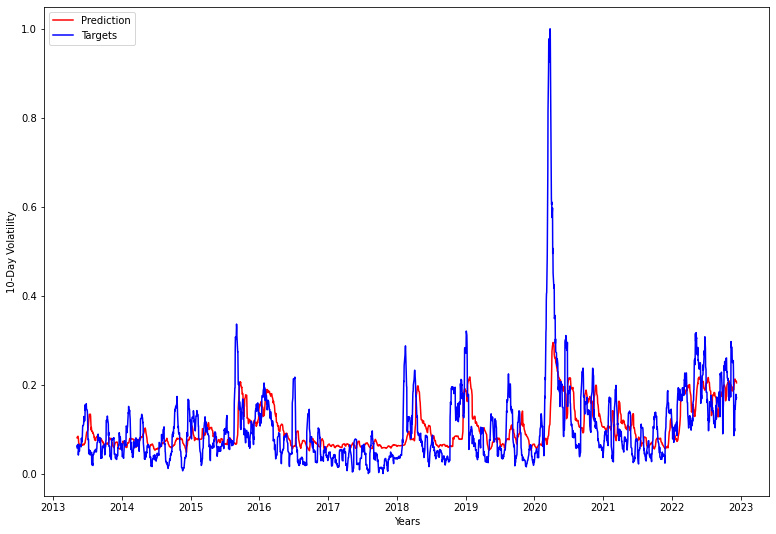

In [20]:
df = data.copy()
df = df.tail(len(preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = preds

# Generate output
plt.figure(figsize=(13,9))
plt.plot(df.index, preds, label="Prediction", color="red")
plt.plot(df.index, targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

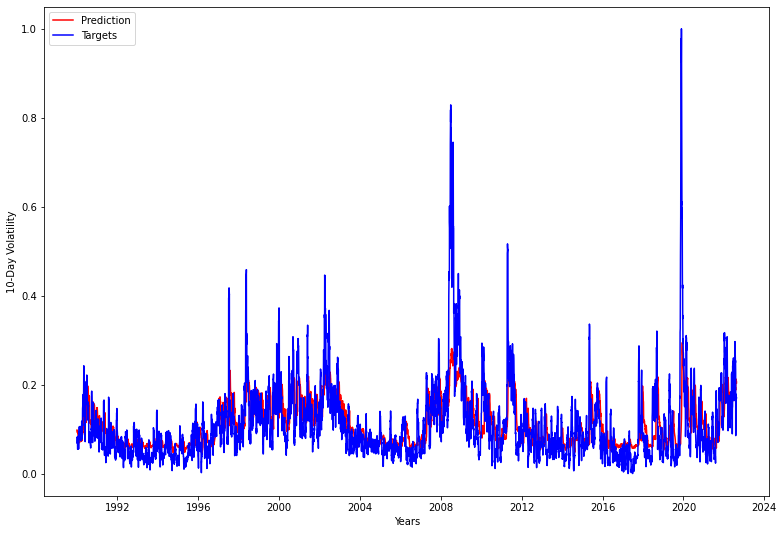

Test loss : 0.005051954


In [21]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, test_loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)